In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple neural network for MNIST with GRPO
class MNIST_GRPO(nn.Module):
    def __init__(self):
        super(MNIST_GRPO, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten image
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax (will be handled in loss)
        return x

# GRPO Training Function with loss tracking
def train_grpo(model, train_loader, optimizer, epochs=5, num_samples=6):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Step 1: Sample multiple predictions
            sampled_outputs = []
            logits = model(images)

            for _ in range(num_samples):
                sampled_outputs.append(torch.multinomial(F.softmax(logits, dim=1), num_samples=1))

            sampled_outputs = torch.cat(sampled_outputs, dim=1)  # Shape: [batch, num_samples]

            # Step 2: Compute Rewards
            rewards = (sampled_outputs == labels.view(-1, 1)).float()  # Reward = 1 if correct, else 0

            # Step 3: Compute Advantage
            mean_reward = rewards.mean(dim=1, keepdim=True)
            advantages = rewards - mean_reward  # Compute relative advantage

            # Step 4: Compute Policy Loss
            log_probs = torch.log_softmax(logits, dim=1)
            selected_log_probs = log_probs.gather(1, sampled_outputs)  # Get log probabilities of sampled outputs
            loss = (-selected_log_probs * advantages).mean()  # Policy Gradient Loss

            # Step 5: Backpropagation and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        loss_history.append(epoch_loss)
        epoch_time = time.time() - start_time

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s")

    return loss_history

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize model, optimizer
model = MNIST_GRPO().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model using GRPO and collect loss history
loss_history = train_grpo(model, train_loader, optimizer, epochs=30)

Epoch 1, Loss: -0.0325, Time: 13.51s
Epoch 2, Loss: -0.0129, Time: 13.45s
Epoch 3, Loss: -0.0142, Time: 13.46s
Epoch 4, Loss: -0.0101, Time: 13.59s
Epoch 5, Loss: -0.0084, Time: 13.48s
Epoch 6, Loss: -0.0076, Time: 13.41s
Epoch 7, Loss: -0.0068, Time: 13.46s
Epoch 8, Loss: -0.0053, Time: 13.51s
Epoch 9, Loss: -0.0055, Time: 13.38s
Epoch 10, Loss: -0.0043, Time: 13.33s
Epoch 11, Loss: -0.0040, Time: 13.32s
Epoch 12, Loss: -0.0040, Time: 13.33s
Epoch 13, Loss: -0.0035, Time: 13.33s
Epoch 14, Loss: -0.0035, Time: 13.39s
Epoch 15, Loss: -0.0032, Time: 13.36s
Epoch 16, Loss: -0.0034, Time: 13.46s
Epoch 17, Loss: -0.0027, Time: 13.41s
Epoch 18, Loss: -0.0027, Time: 13.35s
Epoch 19, Loss: -0.0019, Time: 13.40s
Epoch 20, Loss: -0.0024, Time: 13.41s
Epoch 21, Loss: -0.0021, Time: 13.36s
Epoch 22, Loss: -0.0020, Time: 13.37s
Epoch 23, Loss: -0.0021, Time: 13.44s
Epoch 24, Loss: -0.0018, Time: 13.52s
Epoch 25, Loss: -0.0020, Time: 13.44s
Epoch 26, Loss: -0.0018, Time: 13.55s
Epoch 27, Loss: -0.00

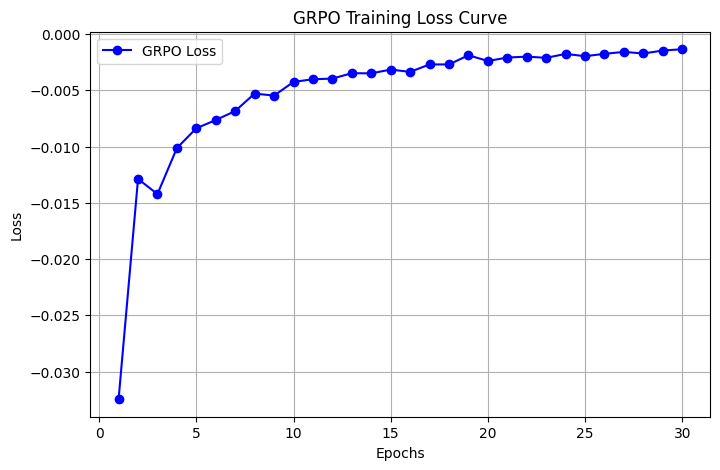

In [36]:
# Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 31), loss_history, marker='o', linestyle='-', color='b', label="GRPO Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("GRPO Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Function to evaluate the trained model on the MNIST test set
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            predictions = torch.argmax(logits, dim=1)  # Get the class with the highest probability

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

# Load MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the trained GRPO model
grpo_accuracy = evaluate_model(model, test_loader)

print(f"GRPO Test Accuracy: {grpo_accuracy:.2f}%")

# Return accuracy result
grpo_accuracy


GRPO Test Accuracy: 96.84%


96.84